## Applying Dyna-Q in a non-deterministic environment

In this notebook, I will explore the recommended application of Dyna-Q in [Sutton's book](https://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html), but to a non-deterministic environment. The goal is to show how the simplest model performs under environment stochasticity.

### Implementing the environment and agents

To simplify this element of the analysis, I will be using the gym library by OpenAI for this assignment.

#### Environment

In this assignment, the environment is the Taxi problem. The goal of the agent is to pick up a passenger and drop it at destination.

There is randomness in the environment because at each reset, the location of the passenger, the destination of the passenger and the initial location of the taxi are random. Indeed, the passenger can be at any of the 4 letters in the map, and the location can be at any other 3 destination where the passenger is not currently at. The taxi also starts at a random position in the map.

In the rendering of the map, the blue letter represents the passenger, the magenta letter the destination, and the color of the cursor is yellow if the taxi is empty and green when the passenger is inside.

#### Reward system

- There is a reward of 20 for bringing the passenger at the correct destination.
- There is a reward of -1 for every timestep (i.e. time before passenger gets to destination)
- There is a reward of -10 if the passenger is brought at the wrong destination.

#### Set of actions

- The agent can either move North, West, East, South.
- The agent can either dropoff or pickup the client.
- Only one action per step.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle as pkl
import gym
import pandas
import random
import collections

In [2]:
env = gym.make('Taxi-v2')
env.render()

[2017-02-16 20:58:39,716] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
def movingAverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, mode='same')

def plot_avg_episode(list, avg_length, xlim=None, ylim=None):
    # plot the results

    x = np.arange(len(list[0]))
    
    avg_0 = pandas.rolling_mean(np.asarray(list[0]), avg_length, min_periods=1)
    avg_1 = pandas.rolling_mean(np.asarray(list[1]), avg_length, min_periods=1)
    avg_2 = pandas.rolling_mean(np.asarray(list[2]), avg_length, min_periods=1)
    
    plt.plot(x, avg_0, label='Q learning w/o plan')
    plt.plot(x, avg_1, label='Q learning w/ plan 2')
    plt.plot(x, avg_2, label='Q learning w/ plan 5')

    plt.legend(loc='lower right')
    plt.xlabel('episode')
    plt.ylabel('avg reward over previous episodes')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

### Implementing Tabular Dyna-Q

Under Dyna-Q, the concept is to generate additional *simulations* in order to improve the value-action function, to allow for better decision making under in the *real* environment. This could be beneficial for intuitive reasons in real world applications where either real environment interaction is expensive, dangerous or other unfeasible manner. Learning from simulations therefore allows for a cheaper and more secure way for the agent to *train* and better approximate the value functions.

In some cases, it can even be safer for the environment itself (e.g. robots trying to drive...), but that is another discussion in itself!

#### Details on Dyna-Q

The planning part of Dyna-Q is the only different thing with typical Q-learning. The way it works is it builds a database of all the previous states and actions encountered and model the rewards and transitions for further improving the model.

Here is the algorithm in detail:
<img src='dyna_q_algo.png'>

It is in the step (f) in the above figure, that the planning step appears. When initially presented with this approach (chapter 8), the book suggests that we should model the state action pair by storing what is the reward experience following a that action from this given state.

The goal is for a given number of planning steps, we sample from our history or previous actions and states visited, then extract from our model the resulting following state and reward. An update to the Q values is performed just like regular Q-learning as if this was a newly sampled data point from the environment. This is then repeated for each planning steps before the agent truly executes another step in the _real world_.

In [14]:
nb_states = env.observation_space.n
nb_actions = env.action_space.n

# Settings for learning
nb_episodes = 2000
init_epsilon = 0.1
learn_rate = 0.8
gamma = 0.8
plan_steps = [0, 2, 5]

rwrd_lst = []
step_lst = []
rwrd_lst_np = []
last_Q_sa = []

for n, planning_steps in enumerate(plan_steps):
    
    print 'Start training w/ %s planning step(s)...' % planning_steps
    
    # Initiate lists and dicts
    Q_sa = np.ones((nb_states, nb_actions)) * 5
    rwrd_lst.append([])
    step_lst.append([])
    sa_history = {}
    model = {}

    for episode_ID in xrange(1, nb_episodes+1):

        # reset the environment
        curr_state = env.reset()
        
        epsilon = init_epsilon

        # reset params for the episode
        steps = 0
        tot_rwrd = 0
        done = False

        # loop until end of episode or over nb_steps
        while not done:
            steps += 1

            if np.random.random_sample() <= epsilon:
                # choose action at random
                action = np.random.randint(nb_actions)
            else:
                # choose greedy action
                action = np.argmax(Q_sa[curr_state, :])

            # get new_state, reward for action and if reached the goal
            new_state, rwrd, done, _ = env.step(action)

            tot_rwrd += rwrd

            # Apply Q-learning
            Q_sa_prime = np.max(Q_sa[new_state, :]) 
            Q_sa[curr_state, action] += learn_rate * (rwrd + gamma * Q_sa_prime 
                                                      - Q_sa[curr_state, action]) 
            
            if planning_steps > 0:
                
                # add the current state and action to the list of previous visits
                if curr_state not in sa_history.keys():
                    sa_history[curr_state] = []

                if action not in sa_history[curr_state]:
                    sa_history[curr_state].append(action)
                    model[(curr_state, action)] = (rwrd, new_state)
                
                for _ in xrange(planning_steps):
                
                    # get random action and state based on previous visits
                    rdm_curr_state = random.choice(sa_history.keys())
                    rdm_action = random.choice(sa_history[rdm_curr_state])

                    sim_reward, sim_new_state = model[(rdm_curr_state, rdm_action)]
                    
                    # Apply Q-learning
                    Q_sa_prime = np.max(Q_sa[sim_new_state, :]) 
                    Q_sa[rdm_curr_state, rdm_action] += learn_rate * (rwrd + gamma * Q_sa_prime 
                                                                      - Q_sa[rdm_curr_state, rdm_action]) 
            
            curr_state = new_state

        step_lst[n].append(steps)
        rwrd_lst[n].append(tot_rwrd)

        if episode_ID % (nb_episodes / 10) == 0:
            print '- Qlearn episode %s tot reward %s' %(episode_ID, tot_rwrd)
            if episode_ID == nb_episodes:
                last_Q_sa.append(Q_sa)
            

    print 'training done.'
    rwrd_lst_np.append(np.asarray(rwrd_lst[n]))
    print 'last 100 avg:', np.average(rwrd_lst_np[n][-100])

Start training w/ 0 planning step(s)...
- Qlearn episode 200 tot reward 4
- Qlearn episode 400 tot reward -4
- Qlearn episode 600 tot reward 2
- Qlearn episode 800 tot reward -6
- Qlearn episode 1000 tot reward 3
- Qlearn episode 1200 tot reward 6
- Qlearn episode 1400 tot reward 5
- Qlearn episode 1600 tot reward 12
- Qlearn episode 1800 tot reward 1
- Qlearn episode 2000 tot reward 0
training done.
last 100 avg: 5.0
Start training w/ 2 planning step(s)...
- Qlearn episode 200 tot reward -468
- Qlearn episode 400 tot reward -144
- Qlearn episode 600 tot reward 13
- Qlearn episode 800 tot reward -104
- Qlearn episode 1000 tot reward -35
- Qlearn episode 1200 tot reward -4
- Qlearn episode 1400 tot reward -309
- Qlearn episode 1600 tot reward -16
- Qlearn episode 1800 tot reward -4
- Qlearn episode 2000 tot reward 10
training done.
last 100 avg: -54.0
Start training w/ 5 planning step(s)...
- Qlearn episode 200 tot reward -129
- Qlearn episode 400 tot reward -44
- Qlearn episode 600 tot

#### Demonstrating the policy
Below is illustrated the learned policy, with the action under the map. Refer to environment description above for more details regarding the map.

In [15]:
curr_state = env.reset()
epsilon = init_epsilon

Q_sa = last_Q_sa[0] # use the one w/o planning to show optimality

# reset params for the episode
steps = 0
tot_rwrd = 0
done = False

# loop until end of episode or over nb_steps
while not done:
    steps += 1
    env.render()
    # choose greedy action
    action = np.argmax(Q_sa[curr_state, :])

    # get new_state, reward for action and if reached the goal
    new_state, rwrd, done, _ = env.step(action)
    
    tot_rwrd += rwrd
    curr_state = new_state
env.render()
print 'tot reward:', tot_rwrd
print 'number of steps:', steps

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| :_: : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : :_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y|

### Plotting the results
Plotted above are the average rewards over all previous episodes, a higher value is interpreted as being a better performance.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


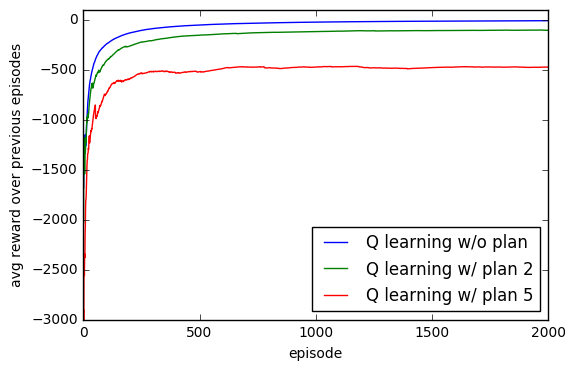

In [6]:
plot_avg_episode(list=rwrd_lst, avg_length=nb_episodes, ylim=[-3000,100])

### Analysis and discussion

We can notice in the figure above that under this environment, adding planning steps actually reduces the performance of our learning algorithm.

The flaw in the implementation is the way the the model is learned and how it evolves in the stochasticity of our environment. In this case, it is simply memorizing the first reward it got out of that action at a particular state, which may not be the same the next time (e.g. the same person to pick-up might not be at the same place, nor the dropoff..).

Planning by using a model as a way to improve the knowledge of different states and actions is a great concept, but it is very dangerous if the model doesn't actually provide useful insight.

In a further assignment, I will likely take this problem again and focus on a better way to deal with a model that can adapt to changes. I can better foresee how implementing machine learning techniques could become very useful in a situation like this.